In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:

import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date_prcp_query = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >='2016-08-23', Measurement.date <='2017-08-23').\
order_by(Measurement.date).statement

In [14]:
# Calculate the date 1 year ago from today

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
date_df = pd.read_sql(date_prcp_query, engine).dropna()
date_df.head()
# Sort the dataframe by date

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79


<IPython.core.display.Javascript object>


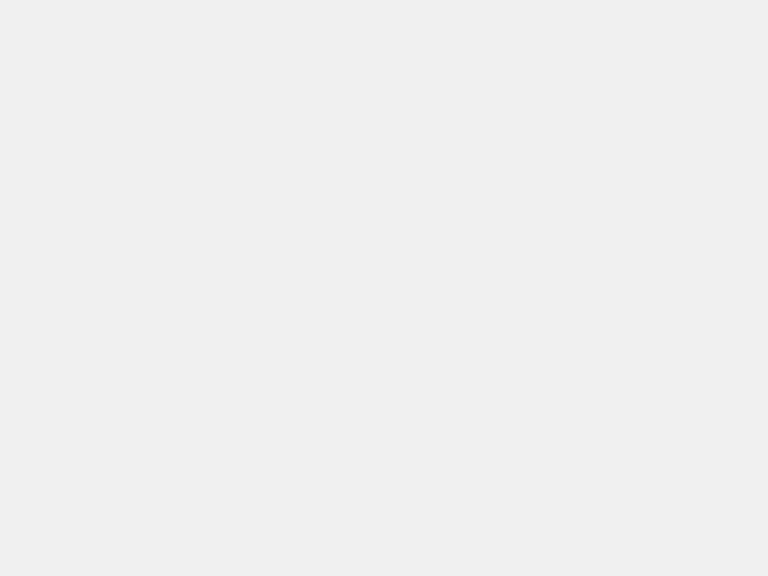

<function matplotlib.pyplot.show(*args, **kw)>

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
date_df['date'] = pd.to_datetime(date_df['date'])
plt.plot(date_df['date'], date_df['prcp'])
plt.title('Percipitation Haiwaii')
plt.xlabel('')
plt.ylabel('Rainfall (Inches)')
plt.xticks(rotation= '90')
plt.tight_layout()
plt.show
# Rotate the xticks for the dates

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# How many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()==session.query(Station.station).distinct().count()
if station_count: 
    num_station = session.query(Measurement.station).distinct().count()
    print(f'The number of stations = {num_station}')
else: 
    print('your database is not NYSNC')

The number of stations = 9


In [20]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = engine.execute('select station, count(station) from measurement group by station order by count(station) desc').fetchall()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_id = active_stations[0][0]
station_name = session.query(Station.name).filter(Station.station==active_stations[0][0]).all()
print(f'The most obs came from {station_name[0][0]}')

The most obs came from WAIHEE 837.5, HI US


In [45]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogr

tobs_query  = session.query(Measurement.tobs, Measurement.station).\
filter(Measurement.date >='2016-08-23', Measurement.date <='2017-08-23').\
filter(Measurement.station==station_id).\
order_by(Measurement.date).statement 

tobs_df = pd.read_sql(tobs_query, engine).dropna()
tobs_df.head(5)

x = tobs_df['tobs']

plt.hist(x, bins=12)
plt.xlabel(r'T ($^\circ$F)')
plt.ylabel('Frequency')
plt.show()

In [41]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_arrive = dt.date(2018, 2, 28)
trip_leave = dt.date(2018, 3, 5)
last_year = dt.timedelta(days=365)
temp_avg_1st_year = (calc_temps((trip_arrive-last_year),(trip_leave-last_year)))
print(temp_avg_1st_year)

[(64.0, 72.02777777777777, 78.0)]


<IPython.core.display.Javascript object>


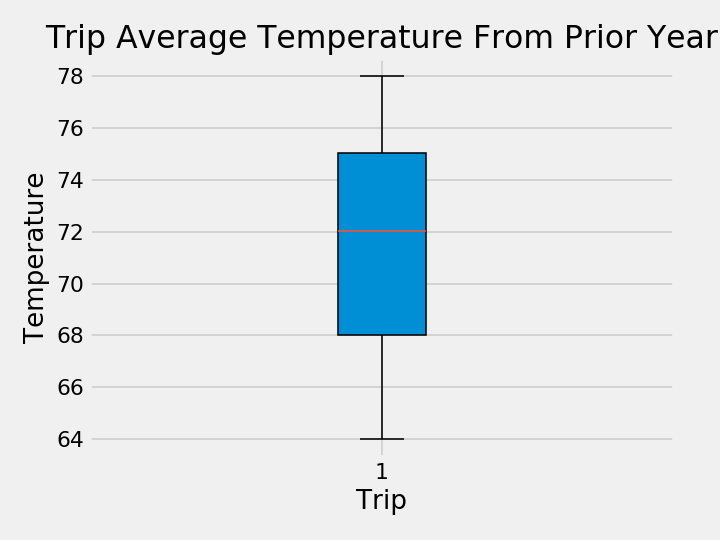

<function matplotlib.pyplot.show(*args, **kw)>

In [50]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
x = range(len(temp_avg_1st_year))
ax.boxplot(temp_avg_1st_year, patch_artist =True)
ax.set_title('Trip Average Temperature From Prior Year')
ax.set_ylabel('Temperature')
ax.set_xlabel('Trip')
fig.tight_layout()
plt.show

<IPython.core.display.Javascript object>


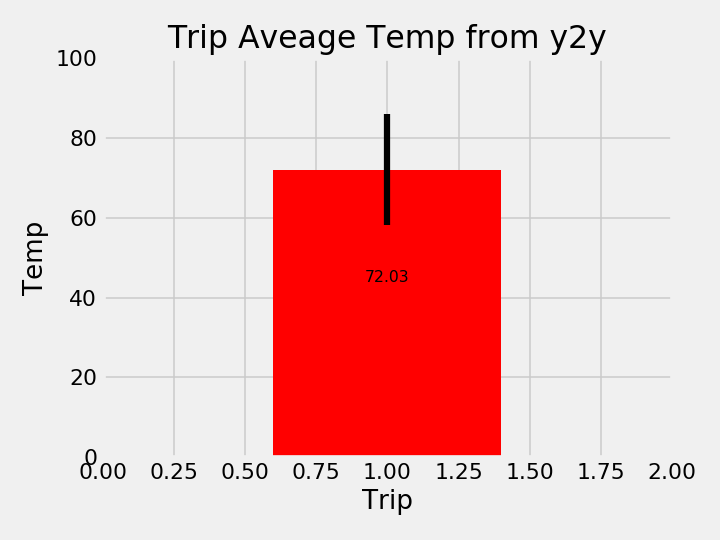

In [53]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
perc = temp_avg_1st_year[0][2]-temp_avg_1st_year[0][0]
avgtemp = temp_avg_1st_year[0][1]
min_temp = temp_avg_1st_year[0][0]
max_temp = temp_avg_1st_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1, avgtemp, color = 'red', yerr=perc)
ax.set_xlabel('Trip')
ax.set_ylabel('Temp')
ax.set_title('Trip Aveage Temp from y2y')

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h),ha='center',va='bottom',fontsize=10)
        
autolabels(bar_chart)
plt.ylim(0, 100)
plt.xlim(0, 2)
fig.tight_layout()
plt.show()

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
